# Initialization
---

### Loading the required Libraries for Time-Series Analysis

In [0]:
%pip install FBProphet

Python interpreter will be restarted.
  Created wheel for FBProphet: filename=fbprophet-0.7.1-py3-none-any.whl size=9534407 sha256=c6969c7343a4ed7402d11eb79514880f3fe115c42715e399ec963fdb43a73935
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built FBProphet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Not uninstalling cmdstanpy at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-cd6ef5e1-8882-45b9-8df1-c91ff6a2e098
    Can't uninstall 'cmdstanpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.
Python interpreter will be restarted.


In [0]:
import logging
logging.getLogger('py4j').setLevel(logging.ERROR)

### Loading the data

In [0]:
df1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/sgoswam@gmu.edu/df1_sample.csv")

In [0]:
df1.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- SPEED: double (nullable = true)
 |-- DATA_AS_OF: string (nullable = true)
 |-- LINK_ID: integer (nullable = true)
 |-- NewDateTime: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_year: integer (nullable = true)



In [0]:
df1 = df1.withColumnRenamed("_c0", "ID")
df1 = df1.withColumnRenamed("NewDateTime", "ds")
df1 = df1.withColumnRenamed("SPEED", "y")
df1 = df1.withColumnRenamed("LINK_ID", "link_id")

In [0]:
from pyspark.sql.types import StringType
df1 = df1.withColumn("link_id",df1.link_id.cast('string'))

In [0]:
df = df1.select('ds', 'link_id', 'y')

In [0]:
from pyspark.sql.functions import count, col

cleaning_filters = (df.ds >= '2018-01-01') & (df.ds < '2022-01-01') & (df.y < 68) & (df.y > 0)

In [0]:
# Filtering rows to clean the data
df = df.filter( cleaning_filters )

In [0]:
df.cache()
df.printSchema()
df.show(10)

root
 |-- ds: timestamp (nullable = true)
 |-- link_id: string (nullable = true)
 |-- y: double (nullable = true)

+-------------------+-------+-----+
|                 ds|link_id|    y|
+-------------------+-------+-----+
|2018-05-26 22:08:04|4616204|41.63|
|2020-12-27 11:47:04|4763652| 9.94|
|2018-07-06 13:18:06|4362252|32.31|
|2021-06-07 01:39:11|4616197|52.81|
|2020-04-23 05:33:04|4616204|44.11|
|2019-09-15 00:57:11|4616281|56.54|
|2020-07-03 03:48:04|4616364|64.62|
|2019-02-16 13:18:03|4616340|27.96|
|2018-11-27 09:38:37|4616226|44.11|
|2020-06-26 19:33:09|4620314|21.12|
+-------------------+-------+-----+
only showing top 10 rows



In [0]:
df.createOrReplaceTempView('data')

# Time-Seriers Analysis | Entire Dataset
---

## Basic Time-Series Data Exploration on entire dataset

#### Overall Trend

In [0]:
%sql
 
SELECT DATE_TRUNC('day', ds) AS Day_Year, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Day_Year
ORDER BY Day_Year DESC;

Day_Year Average_Traffic_Speed 2021-12-31T00:00:00.000+0000 3.72 2021-12-30T00:00:00.000+0000 45.15 2021-12-29T00:00:00.000+0000 46.599999999999994 2021-12-28T00:00:00.000+0000 53.435 2021-12-22T00:00:00.000+0000 35.415 2021-12-21T00:00:00.000+0000 37.69 2021-12-20T00:00:00.000+0000 13.355 2021-12-19T00:00:00.000+0000 13.665000000000001 2021-12-18T00:00:00.000+0000 45.667500000000004 2021-12-17T00:00:00.000+0000 32.72 2021-12-16T00:00:00.000+0000 44.31666666666666 2021-12-15T00:00:00.000+0000 36.5 2021-12-14T00:00:00.000+0000 50.73666666666666 2021-12-13T00:00:00.000+0000 33.86 2021-12-12T00:00:00.000+0000 32.802 2021-12-11T00:00:00.000+0000 29.200000000000003 2021-12-10T00:00:00.000+0000 28.204 2021-12-09T00:00:00.000+0000 48.46 2021-12-08T00:00:00.000+0000 32.9275 2021-12-07T00:00:00.000+0000 43.025000000000006 2021-12-06T00:00:00.000+0000 41.315 2021-12-05T00:00:00.000+0000 30.7525 2021-12-03T00:00:00.000+0000 55.3 2021-12-02T00:00:00.000+0000 9.315000000000001 2021-12-01T00:00:00.000+0000 51.8775 2021-11-30T00:00:00.000+0000 49.705 2021-11-29T00:00:00.000+0000 41.63 2021-11-28T00:00:00.000+0000 43.025 2021-11-27T00:00:00.000+0000 53.587500000000006 2021-11-26T00:00:00.000+0000 38.58888888888888 2021-11-25T00:00:00.000+0000 24.602 2021-11-24T00:00:00.000+0000 36.655 2021-11-23T00:00:00.000+0000 35.0 2021-11-22T00:00:00.000+0000 39.35 2021-11-21T00:00:00.000+0000 35.725 2021-11-20T00:00:00.000+0000 18.945 2021-11-19T00:00:00.000+0000 42.87 2021-11-18T00:00:00.000+0000 6.419999999999999 2021-11-17T00:00:00.000+0000 42.56 2021-11-16T00:00:00.000+0000 51.35999999999999 2021-11-15T00:00:00.000+0000 31.06 2021-11-14T00:00:00.000+0000 53.43333333333333 2021-11-13T00:00:00.000+0000 36.66 2021-11-12T00:00:00.000+0000 28.5775 2021-11-11T00:00:00.000+0000 30.130000000000003 2021-11-10T00:00:00.000+0000 35.725 2021-11-08T00:00:00.000+0000 25.159999999999997 2021-11-07T00:00:00.000+0000 27.18 2021-11-06T00:00:00.000+0000 36.03 2021-11-04T00:00:00.000+0000 30.649999999999995 2021-11-03T00:00:00.000+0000 52.60666666666666 2021-11-02T00:00:00.000+0000 23.19333333333333 2021-10-30T00:00:00.000+0000 21.74 2021-10-28T00:00:00.000+0000 39.556666666666665 2021-10-27T00:00:00.000+0000 29.509999999999998 2021-10-26T00:00:00.000+0000 36.655 2021-10-25T00:00:00.000+0000 55.3 2021-10-24T00:00:00.000+0000 34.48 2021-10-23T00:00:00.000+0000 29.2 2021-10-22T00:00:00.000+0000 49.7 2021-10-21T00:00:00.000+0000 43.244 2021-10-20T00:00:00.000+0000 34.324999999999996 2021-10-19T00:00:00.000+0000 7.76 2021-10-18T00:00:00.000+0000 51.57 2021-10-17T00:00:00.000+0000 25.470000000000002 2021-10-15T00:00:00.000+0000 35.72 2021-10-14T00:00:00.000+0000 35.82777777777778 2021-10-13T00:00:00.000+0000 34.17 2021-10-12T00:00:00.000+0000 12.42 2021-10-11T00:00:00.000+0000 33.34 2021-10-10T00:00:00.000+0000 35.413333333333334 2021-10-09T00:00:00.000+0000 21.12 2021-10-08T00:00:00.000+0000 35.725 2021-10-07T00:00:00.000+0000 24.54 2021-10-06T00:00:00.000+0000 36.034 2021-10-05T00:00:00.000+0000 22.36 2021-10-04T00:00:00.000+0000 48.4625 2021-10-03T00:00:00.000+0000 55.3 2021-10-02T00:00:00.000+0000 7.656666666666666 2021-10-01T00:00:00.000+0000 51.565 2021-09-30T00:00:00.000+0000 30.755000000000003 2021-09-29T00:00:00.000+0000 38.21 2021-09-28T00:00:00.000+0000 38.6725 2021-09-27T00:00:00.000+0000 26.342000000000002 2021-09-26T00:00:00.000+0000 50.95 2021-09-25T00:00:00.000+0000 41.63 2021-09-24T00:00:00.000+0000 33.28428571428571 2021-09-23T00:00:00.000+0000 33.55 2021-09-22T00:00:00.000+0000 31.683333333333334 2021-09-21T00:00:00.000+0000 48.338 2021-09-20T00:00:00.000+0000 47.839999999999996 2021-09-19T00:00:00.000+0000 34.4825 2021-09-18T00:00:00.000+0000 44.11 2021-09-17T00:00:00.000+0000 36.86 2021-09-16T00:00:00.000+0000 50.325 2021-09-15T00:00:00.000+0000 51.56999999999999 2021-09-14T00:00:00.000+0000 28.270000000000003 2021-09-13T00:00:00.000+0000 32.31 2021-09-12T00:00:00.000+0000 55.61 2021-09-11T00:00:00.000+0000 53.846666666666664 2021-09-10T00:00:00.000+0000

In [0]:
%sql

SELECT DATE_TRUNC('MM', ds) AS Month_Years, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Month_Years
ORDER BY Month_Years;

Month_Years Average_Traffic_Speed 2018-01-01T00:00:00.000+0000 40.42082352941178 2018-02-01T00:00:00.000+0000 40.67454545454545 2018-03-01T00:00:00.000+0000 40.98449438202247 2018-04-01T00:00:00.000+0000 37.64195876288658 2018-05-01T00:00:00.000+0000 37.046395348837194 2018-06-01T00:00:00.000+0000 40.993942307692315 2018-07-01T00:00:00.000+0000 39.28589473684211 2018-08-01T00:00:00.000+0000 38.946867469879514 2018-09-01T00:00:00.000+0000 39.53479591836736 2018-10-01T00:00:00.000+0000 36.2702 2018-11-01T00:00:00.000+0000 35.877142857142864 2018-12-01T00:00:00.000+0000 38.78884615384617 2019-01-01T00:00:00.000+0000 41.32255102040816 2019-02-01T00:00:00.000+0000 43.76161290322582 2019-03-01T00:00:00.000+0000 39.482749999999996 2019-04-01T00:00:00.000+0000 41.199677419354835 2019-05-01T00:00:00.000+0000 35.867640449438206 2019-06-01T00:00:00.000+0000 34.623728813559325 2019-07-01T00:00:00.000+0000 37.97444444444444 2019-08-01T00:00:00.000+0000 39.90615384615386 2019-09-01T00:00:00.000+0000 37.691449275362324 2019-10-01T00:00:00.000+0000 38.20971428571426 2019-11-01T00:00:00.000+0000 39.910760869565216 2019-12-01T00:00:00.000+0000 37.56342105263157 2020-01-01T00:00:00.000+0000 40.55478260869566 2020-02-01T00:00:00.000+0000 38.15563218390803 2020-03-01T00:00:00.000+0000 42.131176470588265 2020-04-01T00:00:00.000+0000 48.93617977528092 2020-05-01T00:00:00.000+0000 45.903647058823516 2020-06-01T00:00:00.000+0000 45.315512820512836 2020-07-01T00:00:00.000+0000 43.175373134328375 2020-08-01T00:00:00.000+0000 42.835370370370384 2020-09-01T00:00:00.000+0000 40.311617647058824 2020-10-01T00:00:00.000+0000 40.882209302325585 2020-11-01T00:00:00.000+0000 39.7159090909091 2020-12-01T00:00:00.000+0000 40.2479120879121 2021-01-01T00:00:00.000+0000 41.217560975609764 2021-02-01T00:00:00.000+0000 45.147777777777804 2021-03-01T00:00:00.000+0000 38.17173333333334 2021-04-01T00:00:00.000+0000 37.13232876712328 2021-05-01T00:00:00.000+0000 33.89353846153847 2021-06-01T00:00:00.000+0000 38.45257425742576 2021-07-01T00:00:00.000+0000 39.416162790697676 2021-08-01T00:00:00.000+0000 36.149714285714296 2021-09-01T00:00:00.000+0000 38.04411111111112 2021-10-01T00:00:00.000+0000 34.51256410256413 2021-11-01T00:00:00.000+0000 36.00210526315789 2021-12-01T00:00:00.000+0000 36.96624999999999

#### Annual Pattern

In [0]:
%sql

SELECT DAY(ds) * MONTH(ds) / 30 AS Month, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Month
ORDER BY Month;

Month Average_Traffic_Speed 0.03333333333333333 39.995000000000005 0.06666666666666667 40.058571428571426 0.1 45.7275 0.13333333333333333 42.3029411764706 0.16666666666666666 32.495652173913044 0.2 42.6828 0.23333333333333334 39.301851851851865 0.26666666666666666 42.48125000000001 0.3 40.962413793103444 0.3333333333333333 39.859111111111126 0.36666666666666664 36.800384615384615 0.4 39.78446428571429 0.43333333333333335 43.243 0.4666666666666667 39.56235294117647 0.5 42.9388888888889 0.5333333333333333 38.83829268292682 0.5666666666666667 36.592999999999996 0.6 39.15510638297873 0.6333333333333333 29.664999999999996 0.6666666666666666 37.73897435897435 0.7 43.19875 0.7333333333333333 43.76375000000001 0.7666666666666667 39.263999999999996 0.8 39.36423076923077 0.8333333333333334 41.18764705882353 0.8666666666666667 37.387058823529415 0.9 42.00741935483871 0.9333333333333333 43.08184210526316 0.9666666666666667 40.56142857142857 1.0 38.91737704918034 1.0333333333333334 45.42333333333333 1.0666666666666667 48.59571428571428 1.1 42.90967741935484 1.1333333333333333 45.01636363636364 1.1666666666666667 42.95857142857143 1.2 40.89874999999999 1.2666666666666666 52.35727272727272 1.3 41.08125 1.3333333333333333 41.23592592592592 1.4 44.27069767441861 1.4666666666666666 41.38769230769231 1.5 41.43026315789474 1.5333333333333334 42.11 1.6 40.393382352941174 1.6333333333333333 41.448571428571434 1.6666666666666667 39.50705882352942 1.7 38.874285714285726 1.7333333333333334 41.89333333333333 1.8 33.53511111111111 1.8333333333333333 42.09250000000001 1.8666666666666667 41.14499999999998 1.9 32.073750000000004 1.9333333333333333 44.5775 2.0 38.42086956521739 2.1 36.2976923076923 2.1333333333333333 45.829411764705874 2.1666666666666665 33.66181818181819 2.2 35.49282051282052 2.2666666666666666 37.93933333333334 2.3 44.785 2.3333333333333335 38.95525000000001 2.4 38.22070588235295 2.5 42.17166666666666 2.533333333333333 40.721818181818186 2.566666666666667 38.472307692307695 2.6 39.09862068965517 2.6666666666666665 40.92333333333334 2.7 43.429500000000004 2.8 37.34245614035087 2.8333333333333335 42.994 2.9 40.59222222222222 2.933333333333333 33.297027027027035 3.0 41.86310344827586 3.033333333333333 38.962857142857146 3.066666666666667 44.50818181818182 3.1 39.76181818181818 3.1666666666666665 41.25500000000001 3.2 41.85703703703704 3.2666666666666666 36.302142857142854 3.3 47.18952380952381 3.3333333333333335 33.53166666666667 3.4 46.910000000000004 3.466666666666667 38.7685 3.5 40.1975 3.6 36.004634146341466 3.6666666666666665 37.57666666666667 3.7333333333333334 38.79319999999999 3.8 42.82428571428572 3.8333333333333335 37.97625 3.8666666666666667 37.7535294117647 3.9 37.401999999999994 3.966666666666667 36.28333333333333 4.0 38.06157894736842 4.033333333333333 38.472307692307695 4.166666666666667 32.87090909090909 4.2 37.46400000000001 4.266666666666667 46.039 4.333333333333333 41.58357142857143 4.4 34.32137931034484 4.433333333333334 34.25928571428572 4.5 37.46961538461539 4.533333333333333 46.365 4.6 43.306 4.666666666666667 41.23657142857144 4.766666666666667 33.083333333333336 4.8 37.33021276595744 4.833333333333333 42.07142857142857 4.9 37.815333333333335 5.0 35.68735294117647 5.066666666666666 43.957499999999996 5.1 42.73111111111111 5.133333333333334 43.93571428571428 5.166666666666667 40.127647058823534 5.2 44.180555555555564 5.333333333333333 32.18249999999999 5.366666666666666 49.874545454545455 5.4 37.60368421052632 5.5 39.1857142857143 5.6 38.38953488372093 5.666666666666667 24.78 5.7 35.18125 5.8 49.97285714285715 5.833333333333333 32.307500000000005 5.866666666666666 42.89904761904762 6.0 39.917500000000004 6.066666666666666 38.72833333333333 6.133333333333334 35.70153846153846 6.233333333333333 43.15181818181818 6.3 44.54962962962963 6.333333333333333 32.58222222222222 6.4 44.66789473684211 6.533333333333333 36.38857142857143 6.6 31.734800000000003 6.666666666666667 35.86653846153847 6.766666666666667 37.34777777777778 6

In [0]:
%sql

SELECT MONTH(ds) AS Month, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Month
ORDER BY Month;

Month Average_Traffic_Speed 1 40.908682634730546 2 41.66221476510066 3 40.27437689969605 4 41.33187500000001 5 38.40953846153847 6 40.13008771929823 7 39.74082840236683 8 39.22823529411765 9 38.893169230769224 10 37.45374251497002 11 37.82775384615382 12 38.52183673469386

In [0]:
%sql

SELECT YEAR(ds) AS Year, Month(ds) AS Month, AVG(y) AS Speed
FROM data
GROUP BY Year, Month
ORDER BY Year, Month;

Year Month Speed 2018 1 40.42082352941178 2018 2 40.67454545454545 2018 3 40.98449438202247 2018 4 37.64195876288658 2018 5 37.046395348837194 2018 6 40.993942307692315 2018 7 39.28589473684211 2018 8 38.946867469879514 2018 9 39.53479591836736 2018 10 36.2702 2018 11 35.877142857142864 2018 12 38.78884615384617 2019 1 41.32255102040816 2019 2 43.76161290322582 2019 3 39.482749999999996 2019 4 41.199677419354835 2019 5 35.867640449438206 2019 6 34.623728813559325 2019 7 37.97444444444444 2019 8 39.90615384615386 2019 9 37.691449275362324 2019 10 38.20971428571426 2019 11 39.910760869565216 2019 12 37.56342105263157 2020 1 40.55478260869566 2020 2 38.15563218390803 2020 3 42.131176470588265 2020 4 48.93617977528092 2020 5 45.903647058823516 2020 6 45.315512820512836 2020 7 43.175373134328375 2020 8 42.835370370370384 2020 9 40.311617647058824 2020 10 40.882209302325585 2020 11 39.7159090909091 2020 12 40.2479120879121 2021 1 41.217560975609764 2021 2 45.147777777777804 2021 3 38.17173333333334 2021 4 37.13232876712328 2021 5 33.89353846153847 2021 6 38.45257425742576 2021 7 39.416162790697676 2021 8 36.149714285714296 2021 9 38.04411111111112 2021 10 34.51256410256413 2021 11 36.00210526315789 2021 12 36.96624999999999

In [0]:
%sql

SELECT DAY(ds) * MONTH(ds) / 30 AS Month, YEAR(ds) AS Year, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Month, Year
ORDER BY Month, Year;

Month Year Average_Traffic_Speed 0.03333333333333333 2018 40.385000000000005 0.03333333333333333 2019 25.47 0.03333333333333333 2021 54.26 0.06666666666666667 2018 44.733999999999995 0.06666666666666667 2019 30.9075 0.06666666666666667 2020 46.038 0.06666666666666667 2021 16.775 0.1 2018 50.63666666666666 0.1 2019 42.122 0.1 2020 37.07 0.1 2021 48.151666666666664 0.13333333333333333 2018 35.48111111111111 0.13333333333333333 2019 46.287 0.13333333333333333 2020 45.231 0.13333333333333333 2021 40.757999999999996 0.16666666666666666 2018 21.37 0.16666666666666666 2019 33.550000000000004 0.16666666666666666 2020 42.791250000000005 0.16666666666666666 2021 28.224285714285717 0.2 2018 43.060769230769225 0.2 2019 39.67285714285715 0.2 2020 42.92636363636364 0.2 2021 45.56166666666667 0.23333333333333334 2018 25.470000000000002 0.23333333333333334 2019 46.224 0.23333333333333334 2020 47.715999999999994 0.23333333333333334 2021 38.675000000000004 0.26666666666666666 2018 41.48888888888889 0.26666666666666666 2019 39.452000000000005 0.26666666666666666 2020 48.25444444444444 0.26666666666666666 2021 42.13545454545454 0.3 2018 42.684 0.3 2019 43.04571428571428 0.3 2020 38.05500000000001 0.3 2021 38.44125 0.3333333333333333 2018 37.33454545454545 0.3333333333333333 2019 42.35083333333332 0.3333333333333333 2020 37.36571428571428 0.3333333333333333 2021 43.956250000000004 0.36666666666666664 2018 32.308 0.36666666666666664 2019 36.65749999999999 0.36666666666666664 2020 30.856666666666666 0.36666666666666664 2021 43.80166666666667 0.4 2018 35.82722222222222 0.4 2019 36.17444444444445 0.4 2020 42.96384615384615 0.4 2021 43.683749999999996 0.43333333333333335 2018 36.66 0.43333333333333335 2019 48.465 0.43333333333333335 2020 40.6925 0.43333333333333335 2021 45.35666666666666 0.4666666666666667 2018 38.95076923076923 0.4666666666666667 2019 38.625 0.4666666666666667 2020 33.86000000000001 0.4666666666666667 2021 48.01857142857143 0.5 2018 49.42090909090909 0.5 2019 35.105 0.5 2020 31.188 0.5 2021 45.62285714285714 0.5333333333333333 2018 39.85071428571428 0.5333333333333333 2019 42.81363636363636 0.5333333333333333 2020 35.13777777777777 0.5333333333333333 2021 35.32428571428572 0.5666666666666667 2018 33.13333333333333 0.5666666666666667 2019 25.263333333333332 0.5666666666666667 2020 43.903333333333336 0.5666666666666667 2021 59.03 0.6 2018 47.61363636363637 0.6 2019 34.275 0.6 2020 34.5364705882353 0.6 2021 40.29 0.6333333333333333 2018 27.025 0.6333333333333333 2019 30.75 0.6333333333333333 2020 30.4425 0.6666666666666666 2018 40.3825 0.6666666666666666 2019 43.76375 0.6666666666666666 2020 36.42125 0.6666666666666666 2021 22.45285714285714 0.7 2018 42.495999999999995 0.7 2019 45.541 0.7 2020 39.39 0.7 2021 43.57714285714286 0.7333333333333333 2018 42.311 0.7333333333333333 2019 41.91538461538461 0.7333333333333333 2020 49.648181818181804 0.7333333333333333 2021 41.89428571428572 0.7666666666666667 2018 38.72666666666667 0.7666666666666667 2019 46.596666666666664 0.7666666666666667 2020 39.76 0.7666666666666667 2021 32.303333333333335 0.8 2018 35.03333333333333 0.8 2019 43.523684210526305 0.8 2020 43.714 0.8 2021 32.500625 0.8333333333333334 2018 42.498000000000005 0.8333333333333334 2019 38.93333333333333 0.8333333333333334 2020 55.295 0.8333333333333334 2021 35.8775 0.8666666666666667 2018 26.560000000000002 0.8666666666666667 2019 39.266000000000005 0.8666666666666667 2020 39.76166666666666 0.8666666666666667 2021 47.22 0.9 2018 40.66111111111111 0.9 2019 41.315 0.9 2020 40.19799999999999 0.9 2021 46.129999999999995 0.9333333333333333 2018 40.96399999999999 0.9333333333333333 2019 48.84461538461538 0.9333333333333333 2020 30.7525 0.9333333333333333 2021 44.10999999999999 0.9666666666666667 2018 38.52 0.9666666666666667 2019 55.089999999999996 0.9666666666666667 2021 3.1 1.0 2018 42.721428571428575 1.0 2019 32.0895 1.0 2020 41.28727272727272 1.0 2021 42.31777777777778 1.0333333333333334 2018 49.5 1.0333333333333334 2019 40.38200000000

#### Weekly Pattern

In [0]:
%sql

SELECT HOUR(ds) * DAYOFWEEK(ds) / 24 AS Weekday, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Weekday
ORDER BY Weekday;

Weekday Average_Traffic_Speed 0.0 43.51123376623374 0.041666666666666664 45.42705882352941 0.08333333333333333 44.50526315789473 0.125 45.36822222222222 0.16666666666666666 46.423437500000006 0.20833333333333334 43.308448275862084 0.25 48.32452631578947 0.2916666666666667 45.926 0.3333333333333333 49.41466666666668 0.375 43.590227272727276 0.4166666666666667 46.0007792207792 0.4583333333333333 34.6464705882353 0.5 44.50445378151259 0.5416666666666666 32.984545454545454 0.5833333333333334 37.669473684210544 0.625 43.950909090909086 0.6666666666666666 42.3563768115942 0.7083333333333334 36.00875 0.75 42.89316455696203 0.7916666666666666 32.663333333333334 0.8333333333333334 43.09859649122808 0.875 39.20180555555556 0.9166666666666666 41.427118644067804 0.9583333333333334 42.43846153846153 1.0 37.772976190476186 1.0416666666666667 45.9591891891892 1.0833333333333333 38.58166666666666 1.125 34.29827586206896 1.1666666666666667 38.196338028169016 1.25 39.614545454545464 1.3333333333333333 34.560232558139546 1.375 39.40315789473683 1.4166666666666667 34.5611111111111 1.4583333333333333 39.540188679245276 1.5 39.73591397849463 1.5833333333333333 42.91692307692308 1.625 43.3473076923077 1.6666666666666667 32.09954545454546 1.75 41.87270833333336 1.8333333333333333 35.7040425531915 1.875 33.23283018867924 1.9166666666666667 45.23039999999999 2.0 31.11265625 2.0416666666666665 45.856923076923074 2.0833333333333335 37.65 2.125 31.937037037037047 2.1666666666666665 37.87130434782608 2.25 34.31204545454545 2.2916666666666665 39.78875 2.3333333333333335 39.168085106382975 2.375 40.48157894736842 2.5 36.55659574468085 2.625 41.685 2.6666666666666665 32.33304347826086 2.7083333333333335 35.01681818181817 2.75 39.45208333333333 2.8333333333333335 27.892631578947363 2.875 43.98374999999999 2.9166666666666665 41.10386363636363 3.0 28.933469387755103 3.125 28.479999999999993 3.1666666666666665 41.90058823529412 3.2083333333333335 31.617222222222225 3.25 35.83736842105264 3.3333333333333335 35.56152173913044 3.5 36.001066666666674 3.5416666666666665 35.248000000000005 3.6666666666666665 43.220869565217384 3.75 29.70234042553192 3.7916666666666665 38.71863636363637 3.8333333333333335 39.986799999999995 3.9583333333333335 35.7235 4.0 25.299444444444443 4.083333333333333 35.556363636363635 4.166666666666667 39.71243243243241 4.25 25.9055 4.375 36.75958333333333 4.5 33.116521739130434 4.583333333333333 36.24884615384615 4.666666666666667 32.66095238095238 4.75 37.1525 4.791666666666667 42.66238095238096 4.958333333333333 36.85454545454545 5.0 36.89833333333334 5.25 37.78970588235295 5.5 39.91849999999999 5.541666666666667 34.001363636363635 5.75 41.14333333333333 5.833333333333333 39.02818181818182 6.125 41.81608695652174 6.416666666666667 40.446 6.708333333333333 39.56631578947369

In [0]:
%sql

SELECT DAYOFWEEK(ds) AS Day, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Day
ORDER BY Day;

Day Average_Traffic_Speed 1 40.638482632541105 2 41.15313253012055 3 39.190034782608755 4 39.43307557117751 5 38.18104377104377 6 37.91554474708173 7 40.15977653631288

In [0]:
%sql

SELECT DAYOFWEEK(ds) AS Day, YEAR(ds) AS Year, AVG(y) AS Speed
FROM data
GROUP BY Day, Year
ORDER BY Day, Year;

Day Year Speed 1 2018 38.663223684210514 1 2019 39.6521985815603 1 2020 44.49302325581397 1 2021 40.17504000000001 2 2018 42.09040462427743 2 2019 40.743380281690115 2 2020 44.30201492537314 2 2021 37.16893939393939 3 2018 37.934740259740266 3 2019 38.43814569536424 3 2020 40.63711111111111 3 2021 40.015925925925934 4 2018 38.69363636363637 4 2019 38.57970370370369 4 2020 42.93556390977446 4 2021 37.8225170068027 5 2018 37.27011049723755 5 2019 38.70230158730158 5 2020 41.091805555555545 5 2021 35.94363636363636 6 2018 38.12698529411764 6 2019 36.034583333333345 6 2020 40.91377049180326 6 2021 36.67419117647061 7 2018 38.934716981132084 7 2019 40.719218749999996 7 2020 42.62679687500002 7 2021 38.581065573770516

In [0]:
%sql

SELECT HOUR(ds) * DAYOFWEEK(ds) / 24 AS Day, YEAR(ds) AS Year, AVG(y) AS Speed
FROM data
GROUP BY Day, Year
ORDER BY Day, Year;

Day Year Speed 0.0 2018 45.86644444444446 0.0 2019 44.430731707317065 0.0 2020 43.18939393939394 0.0 2021 39.70942857142857 0.041666666666666664 2018 40.07 0.041666666666666664 2019 39.245 0.041666666666666664 2020 44.42 0.041666666666666664 2021 57.534000000000006 0.08333333333333333 2018 45.2775 0.08333333333333333 2019 42.33714285714286 0.08333333333333333 2020 50.10181818181818 0.08333333333333333 2021 40.125 0.125 2018 45.92416666666667 0.125 2019 41.004999999999995 0.125 2020 50.72090909090909 0.125 2021 44.049 0.16666666666666666 2018 45.589375 0.16666666666666666 2019 47.529999999999994 0.16666666666666666 2020 43.91578947368421 0.16666666666666666 2021 49.75307692307693 0.20833333333333334 2018 41.62545454545454 0.20833333333333334 2019 44.03499999999999 0.20833333333333334 2020 45.0 0.20833333333333334 2021 43.595 0.25 2018 45.23783783783785 0.25 2019 48.59210526315788 0.25 2020 50.91473684210526 0.25 2021 51.31999999999999 0.2916666666666667 2018 45.148666666666664 0.2916666666666667 2019 48.99866666666666 0.2916666666666667 2020 48.53 0.2916666666666667 2021 40.665454545454544 0.3333333333333333 2018 45.53285714285713 0.3333333333333333 2019 47.714666666666666 0.3333333333333333 2020 54.44842105263158 0.3333333333333333 2021 48.098333333333336 0.375 2018 47.276363636363634 0.375 2019 45.88153846153846 0.375 2020 37.01833333333333 0.375 2021 44.65625 0.4166666666666667 2018 45.15894736842105 0.4166666666666667 2019 44.14473684210526 0.4166666666666667 2020 51.306842105263165 0.4166666666666667 2021 43.52299999999999 0.4583333333333333 2018 39.763333333333335 0.4583333333333333 2019 38.985 0.4583333333333333 2020 23.919999999999998 0.4583333333333333 2021 29.326 0.5 2018 47.24033333333333 0.5 2019 45.49444444444445 0.5 2020 42.155185185185196 0.5 2021 43.208 0.5416666666666666 2018 28.517000000000003 0.5416666666666666 2019 29.449 0.5416666666666666 2020 42.792500000000004 0.5416666666666666 2021 33.298 0.5833333333333334 2018 36.14818181818181 0.5833333333333334 2019 39.327999999999996 0.5833333333333334 2020 42.702666666666666 0.5833333333333334 2021 33.71157894736842 0.625 2018 37.54380952380952 0.625 2019 42.040952380952376 0.625 2020 48.284285714285716 0.625 2021 49.37904761904762 0.6666666666666666 2018 44.9621052631579 0.6666666666666666 2019 39.505 0.6666666666666666 2020 40.9435 0.6666666666666666 2021 43.07666666666666 0.7083333333333334 2018 34.347142857142856 0.7083333333333334 2019 36.6575 0.7083333333333334 2020 49.395 0.7083333333333334 2021 31.06333333333334 0.75 2018 45.04312499999999 0.75 2019 40.509 0.75 2020 43.527058823529416 0.75 2021 42.989615384615384 0.7916666666666666 2018 30.708571428571428 0.7916666666666666 2019 28.50666666666666 0.7916666666666666 2020 35.957499999999996 0.7916666666666666 2021 35.41222222222222 0.8333333333333334 2018 39.89875000000002 0.8333333333333334 2019 42.82571428571428 0.8333333333333334 2020 48.02129032258065 0.8333333333333334 2021 41.24782608695652 0.875 2018 27.724374999999995 0.875 2019 41.3675 0.875 2020 43.54521739130435 0.875 2021 42.73111111111112 0.9166666666666666 2018 44.771176470588244 0.9166666666666666 2019 36.864000000000004 0.9166666666666666 2020 49.394 0.9166666666666666 2021 37.42294117647058 0.9583333333333334 2018 38.83 0.9583333333333334 2019 36.5 0.9583333333333334 2020 48.46 0.9583333333333334 2021 52.5 1.0 2018 35.321111111111115 1.0 2019 42.02272727272727 1.0 2020 40.57050000000001 1.0 2021 32.22333333333333 1.0416666666666667 2018 46.25222222222222 1.0416666666666667 2019 45.07777777777778 1.0416666666666667 2020 47.52875000000001 1.0416666666666667 2021 45.299090909090914 1.0833333333333333 2018 41.626999999999995 1.0833333333333333 2019 36.81 1.0833333333333333 2020 39.14 1.0833333333333333 2021 35.857142857142854 1.125 2018 47.21666666666667 1.125 2019 26.714444444444442 1.125 2020 33.99142857142858 1.125 2021 37.463 1.1666666666666667 2018 41.48176470588235 1.1666666666666667 2019 38.141304347826086 1.1666666666666667 2020 38.4516

#### Daily Pattern

In [0]:
%sql

SELECT MINUTE(ds) * HOUR(ds) / 60 AS Hour, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Hour
ORDER BY Hour;

Hour Average_Traffic_Speed 0.0 43.636518987341745 0.05 49.577999999999996 0.06666666666666667 48.089999999999996 0.08333333333333333 54.68 0.1 41.52333333333333 0.13333333333333333 38.775294117647064 0.15 42.496 0.16666666666666666 48.772499999999994 0.18333333333333332 51.254999999999995 0.2 49.23916666666668 0.21666666666666667 50.9475 0.23333333333333334 36.655 0.25 44.11300000000001 0.26666666666666666 45.779545454545456 0.2833333333333333 59.65 0.3 42.998749999999994 0.31666666666666665 48.305 0.3333333333333333 52.81166666666667 0.35 41.75 0.36666666666666664 44.645714285714284 0.38333333333333336 44.42249999999999 0.4 43.268571428571434 0.43333333333333335 40.52846153846153 0.45 40.81461538461539 0.4666666666666667 35.55882352941177 0.48333333333333334 29.82 0.5 39.346666666666664 0.5333333333333333 44.01538461538461 0.55 44.18111111111111 0.5666666666666667 40.135999999999996 0.5833333333333334 29.509999999999998 0.6 42.70870967741936 0.6333333333333333 42.37842105263158 0.65 44.11260869565218 0.6666666666666666 44.764761904761905 0.7 32.56583333333334 0.7166666666666667 41.419999999999995 0.7333333333333333 34.169333333333334 0.75 39.919999999999995 0.7666666666666667 48.66916666666666 0.7833333333333333 55.3 0.8 38.773703703703696 0.8166666666666667 57.036 0.8333333333333334 50.95 0.85 40.17666666666666 0.8666666666666667 44.08052631578946 0.8833333333333333 41.27 0.9 39.92444444444445 0.9333333333333333 44.40529411764706 0.95 38.063333333333325 0.9666666666666667 48.462727272727264 0.9833333333333333 50.330000000000005 1.0 38.64266666666666 1.05 27.599999999999998 1.0666666666666667 33.3425 1.0833333333333333 51.071999999999996 1.1 46.51599999999999 1.1333333333333333 38.272 1.15 44.9621052631579 1.1666666666666667 49.26 1.2 43.46931034482759 1.2666666666666666 49.970000000000006 1.2833333333333334 22.675 1.3 47.27166666666667 1.3333333333333333 39.29583333333334 1.35 36.284000000000006 1.4 37.830000000000005 1.4166666666666667 59.65 1.4333333333333333 50.574000000000005 1.45 48.1525 1.4666666666666666 39.801875 1.5 47.95687500000001 1.5166666666666666 37.65846153846154 1.5333333333333334 47.591333333333324 1.5833333333333333 34.79 1.6 40.90166666666667 1.6333333333333333 41.00666666666667 1.65 48.63928571428572 1.7 45.97571428571429 1.7333333333333334 37.98714285714285 1.75 37.89666666666667 1.7666666666666666 48.54 1.8 47.002608695652164 1.8333333333333333 26.71 1.85 49.394999999999996 1.8666666666666667 37.51944444444444 1.9 44.26916666666667 1.9166666666666667 45.01 1.9333333333333333 43.73076923076923 1.95 35.28866666666667 1.9833333333333334 58.4 2.0 39.17666666666666 2.0166666666666666 56.54 2.1 36.03421052631579 2.1333333333333333 37.525999999999996 2.15 55.919999999999995 2.1666666666666665 34.583333333333336 2.2 46.1325 2.216666666666667 42.095 2.25 31.932000000000006 2.2666666666666666 34.501333333333335 2.3 44.73500000000001 2.3333333333333335 47.03764705882353 2.3833333333333333 28.329999999999995 2.4 39.801874999999995 2.4166666666666665 60.89 2.45 50.23571428571428 2.533333333333333 46.26307692307692 2.55 29.64428571428571 2.566666666666667 27.179999999999996 2.6 32.966249999999995 2.65 44.11142857142857 2.6666666666666665 49.77222222222221 2.683333333333333 51.70214285714286 2.7 41.225882352941184 2.75 48.548571428571435 2.8 43.002857142857145 2.816666666666667 33.093333333333334 2.8333333333333335 46.90833333333333 2.85 41.626666666666665 2.8666666666666667 48.80777777777778 2.9 49.33066666666666 2.933333333333333 44.113571428571426 2.95 55.71 3.0 34.70428571428571 3.033333333333333 39.62555555555556 3.066666666666667 40.43541666666666 3.1166666666666667 47.22 3.15 41.21333333333333 3.1666666666666665 46.84599999999999 3.2 42.45666666666667 3.25 32.59230769230769 3.2666666666666666 47.032500000000006 3.3 40.49636363636363 3.3833333333333333 56.126666666666665 3.4 41.254 3.45 39.846000000000004 3.466666666666667 38.583 3.4833333333333334 47.63333333333333 3.5 45.355714285714285 3.533333333333333 40.9

In [0]:
%sql

SELECT HOUR(ds) AS Hour, AVG(y) AS Average_Traffic_Speed
FROM data
GROUP BY Hour
ORDER BY Hour;

Hour Average_Traffic_Speed 0 43.51123376623374 1 44.99961038961039 2 45.321272727272735 3 46.95908496732028 4 47.629874213836445 5 47.49159793814429 6 44.049209039548025 7 39.03223404255318 8 35.45796052631581 9 38.011878787878786 10 38.56308176100629 11 37.388333333333314 12 34.93790849673202 13 37.41200000000001 14 34.07096153846154 15 32.52493827160495 16 31.19226666666667 17 32.77435064935066 18 33.61314102564102 19 37.89109195402299 20 39.21181818181819 21 42.038855421686755 22 40.24455782312925 23 42.18363636363638

In [0]:
%sql

SELECT HOUR(ds) AS Day, YEAR(ds) AS Year, AVG(y) AS Speed
FROM data
GROUP BY Day, Year
ORDER BY Day, Year;

Day Year Speed 0 2018 45.86644444444446 0 2019 44.430731707317065 0 2020 43.18939393939394 0 2021 39.70942857142857 1 2018 44.598260869565216 1 2019 44.698888888888895 1 2020 46.99472222222222 1 2021 43.818055555555546 2 2018 44.81319148936171 2 2019 45.796052631578945 2 2020 47.49555555555555 2 2021 42.692571428571426 3 2018 46.647105263157904 3 2019 44.395869565217396 3 2020 46.37677419354838 3 2021 50.848947368421044 4 2018 49.02704545454546 4 2019 47.33394736842106 4 2020 45.65794871794871 4 2021 48.33184210526316 5 2018 42.79788461538462 5 2019 47.29851063829787 5 2020 50.80520833333333 5 2021 49.4936170212766 6 2018 43.90500000000001 6 2019 41.70095238095238 6 2020 44.9609756097561 6 2021 45.53108695652173 7 2018 37.47599999999999 7 2019 39.04020408163265 7 2020 42.884499999999996 7 2021 37.46755102040816 8 2018 30.257567567567573 8 2019 33.534651162790695 8 2020 40.13921052631579 8 2021 38.317647058823525 9 2018 38.73263157894738 9 2019 38.30804878048781 9 2020 39.20657894736842 9 2021 36.2425 10 2018 36.80106382978724 10 2019 37.53307692307692 10 2020 42.885789473684206 10 2021 37.383714285714284 11 2018 39.901666666666685 11 2019 40.544516129032274 11 2020 38.071666666666665 11 2021 32.51735849056603 12 2018 37.24761904761906 12 2019 36.17548387096774 12 2020 39.23454545454546 12 2021 29.0408510638298 13 2018 37.22508474576271 13 2019 35.461025641025635 13 2020 43.395757575757564 13 2021 34.904090909090904 14 2018 31.088076923076926 14 2019 35.031612903225806 14 2020 37.55749999999999 14 2021 33.642727272727264 15 2018 31.60135135135135 15 2019 32.19847826086957 15 2020 36.82919999999999 15 2021 26.8 16 2018 28.961470588235297 16 2019 28.54314285714286 16 2020 35.08222222222222 16 2021 31.012222222222217 17 2018 31.865833333333338 17 2019 31.026363636363634 17 2020 40.76451612903226 17 2021 29.28857142857143 18 2018 31.394255319148936 18 2019 31.77705882352942 18 2020 35.7325641025641 18 2021 35.948055555555555 19 2018 37.0782 19 2019 37.95974999999999 19 2020 40.58625 19 2021 36.30227272727274 20 2018 38.67155555555556 20 2019 37.822682926829266 20 2020 43.542708333333316 20 2021 36.197142857142865 21 2018 40.86490566037736 21 2019 38.644000000000005 21 2020 47.780487804878035 21 2021 41.2825925925926 22 2018 41.455882352941174 22 2019 41.60749999999999 22 2020 43.97518518518519 22 2021 34.67378378378378 23 2018 40.812 23 2019 41.212666666666664 23 2020 45.30199999999999 23 2021 42.055172413793095

## Training Model and performing Cross-Validation with Hyper-Parameter Tuning on Sample Data

In [0]:
df_pandas = df.toPandas()

In [0]:
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_pandas)  # Fit model with given params
    df_cv = cross_validation(m, horizon='180 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 02:14:13 and 2021-07-04 02:14:13
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7fa92b139dc0>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 02:14:13 and 2021-07-04 02:14:13
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7fa92aad31c0>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 02:14:13 and 2021-07-04 02:14:13
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7fa92b281340>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 02:14:13 and 2021-07-04 02:14:13
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7fa9147f5fa0>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 02:14:13 and 2021-07-04 02:14:13
INFO:prophet:Applying in parallel with <concurrent.futures.thread.Threa

In [0]:
display(tuning_results)

changepoint_prior_scale seasonality_prior_scale rmse 0.01 0.01 15.796658470816157 0.01 0.1 15.857775895599811 0.1 0.01 15.935684051985374 0.1 0.1 16.00211449559187 0.5 0.01 16.052532924229794 0.5 0.1 15.93716293179397

In [0]:
# Getting best parameters to train the model
print(tuning_results[tuning_results.rmse == tuning_results.rmse.min()])

   changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.01                     0.01  15.796658


## Training Time-Series Model

In [0]:
# Preparing the input for training model

train = '''
SELECT ds, AVG(y) AS y
FROM data
GROUP BY ds
ORDER BY ds;
'''

df_train = spark.sql(train).toPandas()

In [0]:
# Training the prophet model on the training set
from fbprophet import Prophet

ts_model = Prophet(
    changepoint_prior_scale=0.5,    # determines flexibility of trend
    seasonality_prior_scale=0.01,   # determines flexbility of seasonality
    interval_width=0.9,             # defines Confidence Interval for predections
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

ts_model.fit( df_train )

Out[25]: <fbprophet.forecaster.Prophet at 0x7fa93c96ad90>

In [0]:
# Predicting future for 'fut' more days

fut = 365*24*2
df_future = ts_model.make_future_dataframe(
    periods=fut,
    freq='H',
    include_history=True
)

# predict over the dataset
df_forecast = ts_model.predict(df_future)

display(df_forecast)

ds trend yhat_lower yhat_upper trend_lower trend_upper additive_terms additive_terms_lower additive_terms_upper daily daily_lower daily_upper weekly weekly_lower weekly_upper multiplicative_terms multiplicative_terms_lower multiplicative_terms_upper yhat 2018-01-01T01:22:15.000+0000 40.61159045687531 17.741464692593468 69.0216868406523 40.61159045687531 40.61159045687531 4.3438638163818135 4.3438638163818135 4.3438638163818135 3.3246903943446573 3.3246903943446573 3.3246903943446573 1.0191734220371553 1.0191734220371553 1.0191734220371553 0.0 0.0 0.0 44.955454273257125 2018-01-01T22:17:18.000+0000 40.600666091726914 17.242435525854898 68.39205087395521 40.600666091726914 40.600666091726914 2.322595598931118 2.322595598931118 2.322595598931118 1.8486719837676975 1.8486719837676975 1.8486719837676975 0.473923615163421 0.473923615163421 0.473923615163421 0.0 0.0 0.0 42.92326169065803 2018-01-02T10:41:18.000+0000 40.594190072707434 14.250430059886627 63.98125950363528 40.594190072707434 40.594190072707434 -1.5685571887702447 -1.5685571887702447 -1.5685571887702447 -1.7365957649162713 -1.7365957649162713 -1.7365957649162713 0.16803857614602713 0.16803857614602713 0.16803857614602713 0.0 0.0 0.0 39.02563288393719 2018-01-02T14:57:19.000+0000 40.59196162001572 11.367516237760277 60.902871503003695 40.59196162001572 40.59196162001572 -5.145577728680097 -5.145577728680097 -5.145577728680097 -5.244216354456771 -5.244216354456771 -5.244216354456771 0.09863862577667476 0.09863862577667476 0.09863862577667476 0.0 0.0 0.0 35.44638389133562 2018-01-02T20:49:24.000+0000 40.5888969716782 16.992670088912543 67.40410175866928 40.5888969716782 40.5888969716782 0.42323555799889584 0.42323555799889584 0.42323555799889584 0.38587364403519814 0.38587364403519814 0.38587364403519814 0.03736191396369781 0.03736191396369781 0.03736191396369781 0.0 0.0 0.0 41.012132529677096 2018-01-03T16:36:51.000+0000 40.578561019010614 8.514593423342824 58.427404307483414 40.578561019010614 40.578561019010614 -6.407113298041283 -6.407113298041283 -6.407113298041283 -6.205389382501103 -6.205389382501103 -6.205389382501103 -0.20172391554017957 -0.20172391554017957 -0.20172391554017957 0.0 0.0 0.0 34.17144772096933 2018-01-03T23:17:03.000+0000 40.57507754748965 16.85381403229523 67.09346078380995 40.57507754748965 40.57507754748965 1.771316162930757 1.771316162930757 1.771316162930757 2.2220221815880206 2.2220221815880206 2.2220221815880206 -0.4507060186572632 -0.4507060186572632 -0.4507060186572632 0.0 0.0 0.0 42.34639371042041 2018-01-03T23:42:03.000+0000 40.574859939323666 17.52378094767874 67.22038591520766 40.574859939323666 40.574859939323666 1.8538576035814889 1.8538576035814889 1.8538576035814889 2.3239193082806784 2.3239193082806784 2.3239193082806784 -0.47006170469918945 -0.47006170469918945 -0.47006170469918945 0.0 0.0 0.0 42.428717542905154 2018-01-04T05:02:03.000+0000 40.572074554799165 22.45556704666496 69.62711411975376 40.572074554799165 40.572074554799165 5.84631052682333 5.84631052682333 5.84631052682333 6.595593109281192 6.595593109281192 6.595593109281192 -0.7492825824578621 -0.7492825824578621 -0.7492825824578621 0.0 0.0 0.0 46.418385081622496 2018-01-04T14:42:03.000+0000 40.56702604534849 8.876928358286467 59.10689834070768 40.56702604534849 40.56702604534849 -6.153433390473209 -6.153433390473209 -6.153433390473209 -4.8512203003795396 -4.8512203003795396 -4.8512203003795396 -1.30221309009367 -1.30221309009367 -1.30221309009367 0.0 0.0 0.0 34.41359265487528 2018-01-04T20:07:10.000+0000 40.564196123686 13.97712619724482 64.11254311149347 40.564196123686 40.564196123686 -2.286133235466746 -2.286133235466746 -2.286133235466746 -0.7467438666774214 -0.7467438666774214 -0.7467438666774214 -1.539389368789325 -1.539389368789325 -1.539389368789325 0.0 0.0 0.0 38.27806288821925 2018-01-05T05:02:04.000+0000 40.559540179366756 19.02959870596163 69.06880298290538 40.559540179366756 40.559540179366756 4.954279061849237 4.954279061849237 4.954279061849237 6.5952810

In [0]:
df_forecast.tail(5)

ds 
 trend 
 yhat_lower 
 yhat_upper 
 trend_lower 
 trend_upper 
 additive_terms 
 additive_terms_lower 
 additive_terms_upper 
 daily 
 daily_lower 
 daily_upper 
 weekly 
 weekly_lower 
 weekly_upper 
 multiplicative_terms 
 multiplicative_terms_lower 
 multiplicative_terms_upper 
 yhat 
 
 
 
 
 21427 
 2023-12-30 22:14:13 
 25.206415 
 -5.421368 
 63.397424 
 1.429022 
 49.721239 
 2.891382 
 2.891382 
 2.891382 
 1.818591 
 1.818591 
 1.818591 
 1.072791 
 1.072791 
 1.072791 
 0.0 
 0.0 
 0.0 
 28.097797 
 
 
 21428 
 2023-12-30 23:14:13 
 25.205835 
 -5.186509 
 61.244628 
 1.426035 
 49.722115 
 3.314483 
 3.314483 
 3.314483 
 2.210201 
 2.210201 
 2.210201 
 1.104281 
 1.104281 
 1.104281 
 0.0 
 0.0 
 0.0 
 28.520318 
 
 
 21429 
 2023-12-31 00:14:13 
 25.205255 
 -5.788308 
 64.993117 
 1.423048 
 49.722991 
 3.628251 
 3.628251 
 3.628251 
 2.496218 
 2.496218 
 2.496218 
 1.132033 
 1.132033 
 1.132033 
 0.0 
 0.0 
 0.0 
 28.833506 
 
 
 21430 
 2023-12-31 01:14:13 
 25.204674 
 -4.204341 
 64.027273 
 1.420061 
 49.723867 
 4.339880 
 4.339880 
 4.339880 
 3.183732 
 3.183732 
 3.183732 
 1.156149 
 1.156149 
 1.156149 
 0.0 
 0.0 
 0.0 
 29.544555 
 
 
 21431 
 2023-12-31 02:14:13 
 25.204094 
 -5.278479 
 65.896883 
 1.417074 
 49.724743 
 5.672138 
 5.672138 
 5.672138 
 4.495394 
 4.495394 
 4.495394 
 1.176744 
 1.176744 
 1.176744 
 0.0 
 0.0 
 0.0 
 30.876232

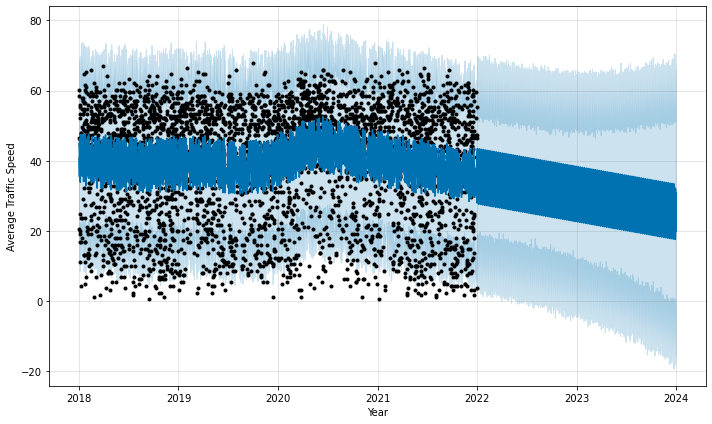

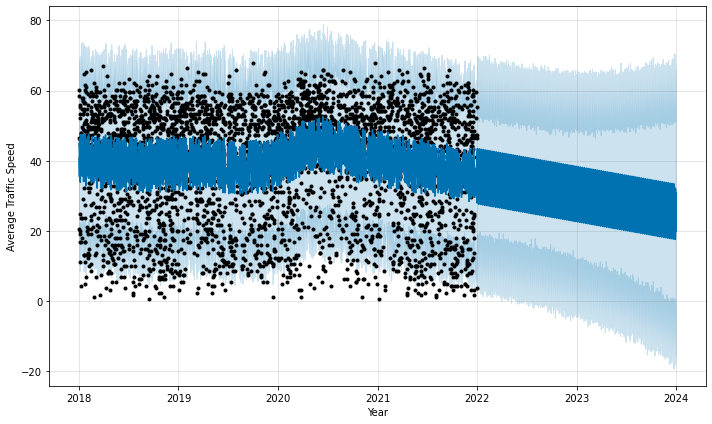

In [0]:
#after tuning
fig_trends = ts_model.plot(df_forecast, xlabel='Year', ylabel='Average Traffic Speed')
display(fig_trends)

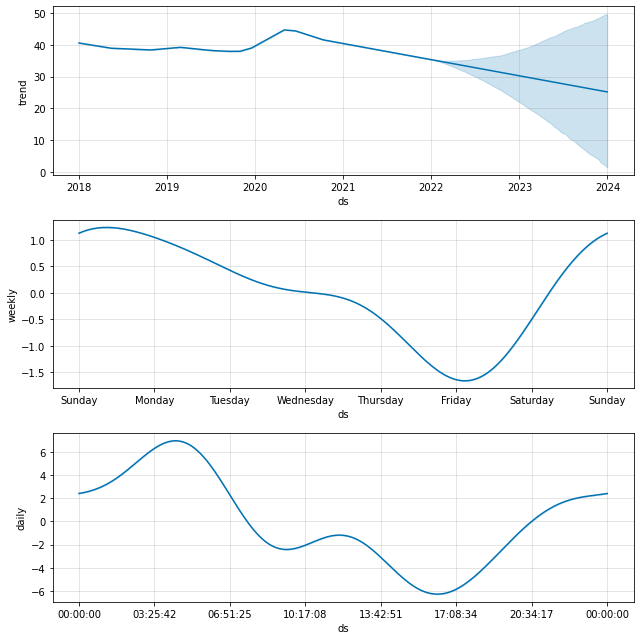

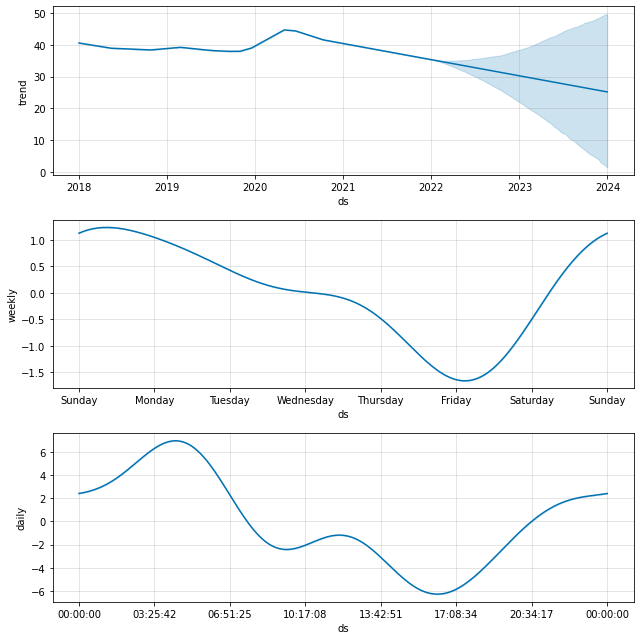

In [0]:
# after tuning
fig_components = ts_model.plot_components(df_forecast)
display(fig_components)

In [0]:
from prophet.plot import plot_plotly

plot_plotly(ts_model, df_forecast, xlabel='Date', ylabel='Average Traffic Speed')